In [1]:
if "running_all" not in globals():
    from ipywidgets import widgets
    matrices = ["bcsstk18", "cbuckle", "ct20stif", "raefsky4", "vanbody"]
    b = widgets.Button(description="Run over all matrices", button_style="success")
    output = widgets.Output()

    display(b, output)

    def run_over_all_matrices(button):
        global running_all
        global matrix
        running_all = True
        with output:
            for matrix in matrices:
                print(f"Running {matrix}...")
                %run ./model_evaluation.ipynb # will output at this cell rather than later
            print("Finished!")
    b.on_click(run_over_all_matrices)

Button(button_style='success', description='Run over all matrices', style=ButtonStyle())

Output()

In [2]:
if "running_all" not in globals():
    matrix = "bcircuit"  # manually set to run over one matrix
matrix

'bcircuit'

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from glob import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

In [4]:
test_data_sizes = {
    "bcsstk18": 1000,
    "cbuckle": 1000,
    "ct20stif": 1000,
    "raefsky4": 1000,
    "vanbody": 100,
    "Pres_Poisson": 1000,
    "Na5": 1000,
    "bcircuit": 1000,
}

df = pd.read_csv(f"data/{matrix}_{test_data_sizes[matrix]}.csv")
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,bcircuit.mat,48,0.000001,4800,19468,31,41,8.511686e-07,True,0.095583,0.503071,68902,0.854167
1,bcircuit.mat,48,0.000001,4800,21329,34,47,9.993444e-07,True,0.109453,0.445820,68902,0.979167
2,bcircuit.mat,48,0.000001,4800,8393,47,120,9.675828e-07,True,0.243944,72.526651,68902,2.500000
3,bcircuit.mat,48,0.000001,4800,15359,0,66,8.734661e-07,True,0.153866,276.799212,68902,1.375000
4,bcircuit.mat,48,0.000001,4800,62795,14,58,8.709925e-07,True,0.137443,0.045752,68902,1.208333


In [5]:
df.sort_values("slowdown", inplace=False, ascending=False).head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
465,bcircuit.mat,48,0.000001,4800,27724,12,4799,0.000006,False,8.714337,377.635013,68902,99.979167
842,bcircuit.mat,48,0.000001,4800,49080,26,4799,0.000005,False,9.335167,2571.887697,68902,99.979167
302,bcircuit.mat,48,0.000001,4800,13199,12,4799,0.000035,False,9.115005,2571.321913,68902,99.979167
877,bcircuit.mat,48,0.000001,4800,53046,18,4799,0.000006,False,9.108365,2571.887697,68902,99.979167
124,bcircuit.mat,48,0.000001,4800,12557,39,4799,0.000008,False,8.880940,1696.792933,68902,99.979167


In [6]:
X_test = df[["error_iter", "pos_2norm"]].to_numpy()
y_test = df["slowdown"].to_numpy()

In [7]:
p = 1 / 98
1 + (1 / p)

# 1 + (1 / x) = 99
# (1 / x) = 98
# x = 1 / 98

99.00000000000001

In [8]:
models = [load(fn) for fn in glob(f"./models/{matrix}/*.pkl")]
model_names = [model.steps[-1][1].__class__.__name__ for model in models]
ps = list(np.arange(1 / 98, 1, 0.01))

reports = pd.DataFrame(index=ps, columns=model_names)
reports.head()

,Ridge,RandomForestRegressor,KNeighborsRegressor,XGBRegressor,LinearSVR
0.010204,NaN,NaN,NaN,NaN,NaN
0.020204,NaN,NaN,NaN,NaN,NaN
0.030204,NaN,NaN,NaN,NaN,NaN
0.040204,NaN,NaN,NaN,NaN,NaN
0.050204,NaN,NaN,NaN,NaN,NaN


In [9]:
for p in ps:
    for model, name in zip(models, model_names):
        preds = model.predict(X_test)
        y_pred_clas = preds > (1 + (1 / p))
        y_true_clas = y_test > (1 + (1 / p))
        reports.loc[p][name] = {
            "accuracy": accuracy_score(y_true_clas, y_pred_clas),
            "f1_score": f1_score(y_true_clas, y_pred_clas, zero_division=0),
            "precision": precision_score(y_true_clas, y_pred_clas, zero_division=0),
            "recall": recall_score(y_true_clas, y_pred_clas, zero_division=0),
            "f1b_0.5_score": fbeta_score(y_true_clas, y_pred_clas, beta=0.5, zero_division=0),
            "f1b_2_score": fbeta_score(y_true_clas, y_pred_clas, beta=2, zero_division=0)
        }

reports.head()

,Ridge,RandomForestRegressor,KNeighborsRegressor,XGBRegressor,LinearSVR
0.010204,"{'accuracy': 0.99, 'f1_score': 0.0, 'precision...","{'accuracy': 0.99, 'f1_score': 0.0, 'precision...","{'accuracy': 0.99, 'f1_score': 0.0, 'precision...","{'accuracy': 0.992, 'f1_score': 0.333333333333...","{'accuracy': 0.99, 'f1_score': 0.0, 'precision..."
0.020204,"{'accuracy': 0.991, 'f1_score': 0.816326530612...","{'accuracy': 0.992, 'f1_score': 0.84, 'precisi...","{'accuracy': 0.991, 'f1_score': 0.816326530612...","{'accuracy': 0.994, 'f1_score': 0.880000000000...","{'accuracy': 0.984, 'f1_score': 0.6, 'precisio..."
0.030204,"{'accuracy': 0.987, 'f1_score': 0.786885245901...","{'accuracy': 0.986, 'f1_score': 0.78125, 'prec...","{'accuracy': 0.984, 'f1_score': 0.741935483870...","{'accuracy': 0.996, 'f1_score': 0.942857142857...","{'accuracy': 0.982, 'f1_score': 0.653846153846..."
0.040204,"{'accuracy': 0.978, 'f1_score': 0.710526315789...","{'accuracy': 0.984, 'f1_score': 0.794871794871...","{'accuracy': 0.975, 'f1_score': 0.675324675324...","{'accuracy': 0.993, 'f1_score': 0.915662650602...","{'accuracy': 0.979, 'f1_score': 0.666666666666..."
0.050204,"{'accuracy': 0.968, 'f1_score': 0.673469387755...","{'accuracy': 0.984, 'f1_score': 0.843137254901...","{'accuracy': 0.972, 'f1_score': 0.725490196078...","{'accuracy': 0.989, 'f1_score': 0.893203883495...","{'accuracy': 0.97, 'f1_score': 0.5833333333333..."


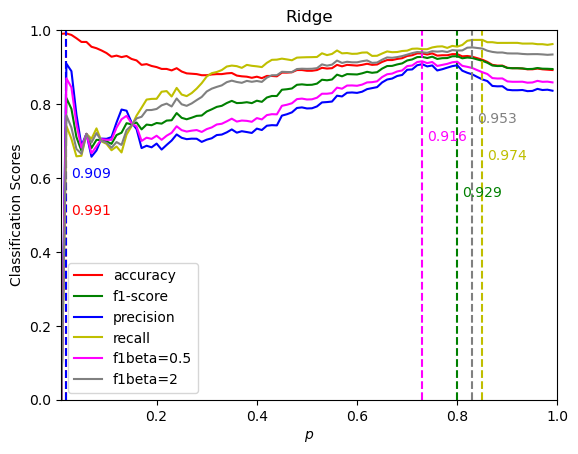

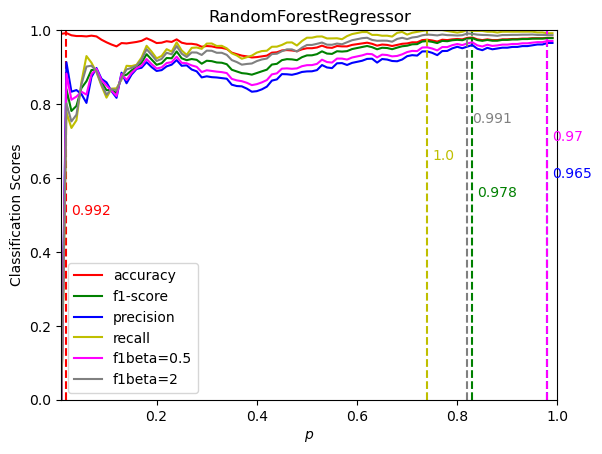

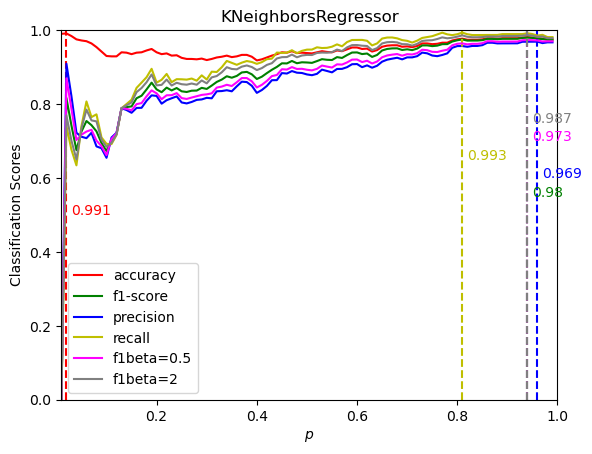

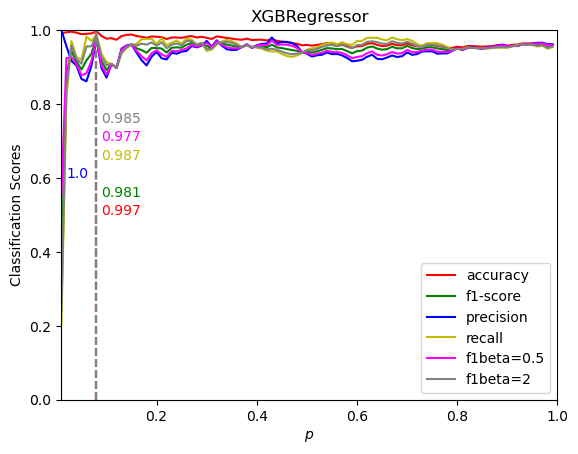

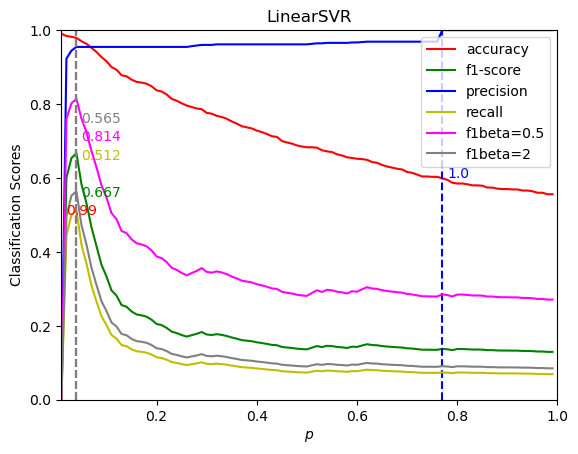

In [10]:
for name, series in reports.items():
    accuracies = [item["accuracy"] for item in series]
    best_acc_p = ps[np.argmax(accuracies)]
    f1_scores = [scores["f1_score"] for scores in series]
    best_f1_p = ps[np.argmax(f1_scores)]

    precisions = [scores["precision"] for scores in series]
    best_precision_p = ps[np.argmax(precisions)]
    recalls = [scores["recall"] for scores in series]
    best_recall_p = ps[np.argmax(recalls)]

    f1b_05s = [scores["f1b_0.5_score"] for scores in series]
    best_f1b_05_p = ps[np.argmax(f1b_05s)]
    f1b_2s = [scores["f1b_2_score"] for scores in series]
    best_f1b_2_p = ps[np.argmax(f1b_2s)]


    plt.plot(ps, accuracies, label=f"accuracy", c="r")
    plt.axvline(x=best_acc_p, linestyle='--', c="r")
    plt.annotate(f"{round(np.max(accuracies), 3)}", xy=(best_acc_p + 0.01, 0.5), c="r")

    plt.plot(ps, f1_scores, label=f"f1-score", c="g")
    plt.axvline(x=best_f1_p, linestyle='--', c="g")
    plt.annotate(f"{round(np.max(f1_scores), 3)}", xy=(best_f1_p + 0.01, 0.55), c="g")

    plt.plot(ps, precisions, label=f"precision", c="b")
    plt.axvline(x=best_precision_p, linestyle='--', c="b")
    plt.annotate(f"{round(np.max(precisions), 3)}", xy=(best_precision_p + 0.01, 0.6), c="b")

    plt.plot(ps, recalls, label=f"recall", c="y")
    plt.axvline(x=best_recall_p, linestyle='--', c="y")
    plt.annotate(f"{round(np.max(recalls), 3)}", xy=(best_recall_p + 0.01, 0.65), c="y")

    plt.plot(ps, f1b_05s, label=f"f1beta=0.5", c="magenta")
    plt.axvline(x=best_f1b_05_p, linestyle='--', c="magenta")
    plt.annotate(f"{round(np.max(f1b_05s), 3)}", xy=(best_f1b_05_p + 0.01, 0.7), c="magenta")
    
    plt.plot(ps, f1b_2s, label=f"f1beta=2", c="grey")
    plt.axvline(x=best_f1b_2_p, linestyle='--', c="grey")
    plt.annotate(f"{round(np.max(f1b_2s), 3)}", xy=(best_f1b_2_p + 0.01, 0.75), c="grey")

    plt.title(name)
    plt.xlabel("$p$")
    plt.ylabel("Classification Scores")
    plt.xlim(1/98, 1)
    plt.ylim(0, 1)
    plt.legend()
    os.makedirs(f"./figures/{matrix}", exist_ok=True)
    plt.savefig(f"./figures/{matrix}/{name}.png")
    plt.show()

In [11]:
avg_metrics = pd.DataFrame()  # columns=["model", "metric", "value"]

avg_metrics["accuracy"] = reports.apply(lambda col: np.mean([scores["accuracy"] for scores in col]))
avg_metrics["f1_score"] = reports.apply(lambda col: np.mean([scores["f1_score"] for scores in col]))
avg_metrics["precision"] = reports.apply(lambda col: np.mean([scores["precision"] for scores in col]))
avg_metrics["recall"] = reports.apply(lambda col: np.mean([scores["recall"] for scores in col]))
avg_metrics["f1b_0.5_score"] = reports.apply(lambda col: np.mean([scores["f1b_0.5_score"] for scores in col]))
avg_metrics["f1b_2_score"] = reports.apply(lambda col: np.mean([scores["f1b_2_score"] for scores in col]))
avg_metrics = avg_metrics.reset_index(names=["model"])
avg_metrics = avg_metrics.melt(id_vars="model", var_name="metric")

avg_metrics

,model,metric,value
0,Ridge,accuracy,0.909323
1,RandomForestRegressor,accuracy,0.963606
2,KNeighborsRegressor,accuracy,0.950798
3,XGBRegressor,accuracy,0.969333
4,LinearSVR,accuracy,0.713747
5,Ridge,f1_score,0.827775
6,RandomForestRegressor,f1_score,0.918625
7,KNeighborsRegressor,f1_score,0.883280
8,XGBRegressor,f1_score,0.942029
9,LinearSVR,f1_score,0.189256


In [12]:
best_models = avg_metrics.loc[avg_metrics.groupby('metric')['value'].idxmax()]
print(f'Best model for f1 is {best_models["model"][best_models["metric"] == "f1_score"].iloc[0]}')
print(f'Best model for f1b_0.5 is {best_models["model"][best_models["metric"] == "f1b_0.5_score"].iloc[0]}')
print(f'Best model for f1b_2 is {best_models["model"][best_models["metric"] == "f1b_2_score"].iloc[0]}')

best_models

Best model for f1 is XGBRegressor
Best model for f1b_0.5 is XGBRegressor
Best model for f1b_2 is XGBRegressor


,model,metric,value
3,XGBRegressor,accuracy,0.969333
8,XGBRegressor,f1_score,0.942029
23,XGBRegressor,f1b_0.5_score,0.939980
28,XGBRegressor,f1b_2_score,0.945594
14,LinearSVR,precision,0.959976
18,XGBRegressor,recall,0.948358


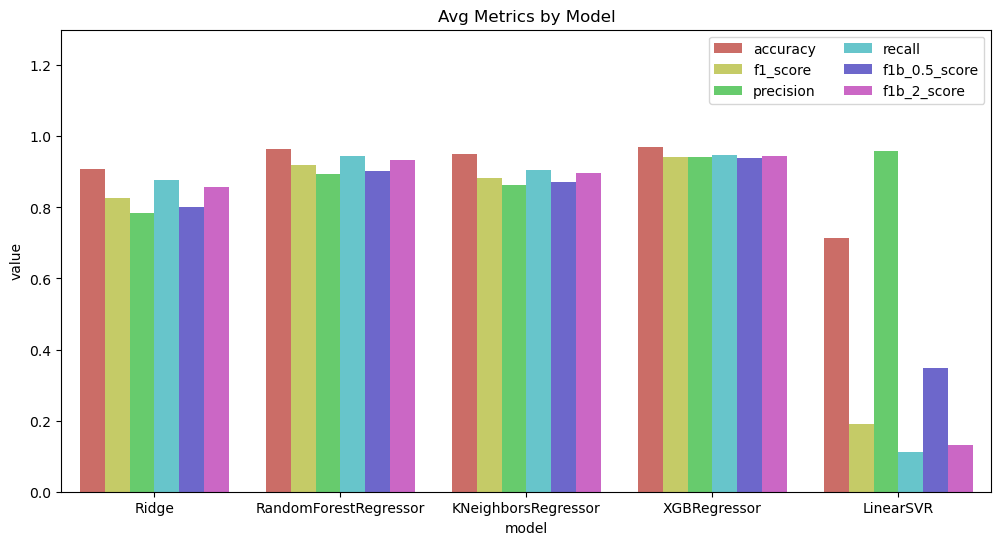

In [13]:
plt.gcf().set_size_inches(12, 6)
plt.gcf().set_dpi(100)
sns.barplot(avg_metrics, x="model", y="value", hue="metric", palette="hls")
plt.ylim(0, 1.3)
plt.title("Avg Metrics by Model")
plt.legend(ncols=2)
plt.savefig(f"./figures/{matrix}/model_avg_metrics.png")
plt.show()